In [24]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from glob import glob
import os
import scipy.io
from sklearn.linear_model import LogisticRegression


In [112]:
CWRU_X_0 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/0.npz")["x"]
CWRU_y_0 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/0.npz")["y"]
CWRU_X_1 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/1.npz")["x"]
CWRU_y_1 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/1.npz")["y"]
#CWRU_X_2 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/2.npz")["x"]
#CWRU_X_3 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/3.npz")["x"]
CWRU_X_all = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/all.npz")["x"]
CWRU_y_all = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/all.npz")["y"]
IMS_X_0 = np.load("/data/home/jkataok1/DA_DFD/data/processed/IMS/0.npz")["x"]
IMS_y_0 = np.load("/data/home/jkataok1/DA_DFD/data/processed/IMS/0.npz")["y"]

In [14]:

def normalize_signal(df):
    mean = df['DE_time'].apply(np.mean)
    std = df['DE_time'].apply(np.std)
    df['DE_time'] = (df['DE_time'] - mean) / std
    return mean, std

def divide_signal(df, segment_length):

    dic = {}
    idx = 0
    for i in range(df.shape[0]): # 파일 개수
        n_sample_points = len(df.iloc[i,1]) # 파일 안에 있는 신호 개수 # 예를들어 122571
        n_segments = n_sample_points // segment_length # 원하는 segment 길이만큼 슬라이싱 할 개수 # 예를 들어 segment_length는 500, n_segments는 245
        for segment in range(n_segments): 
            dic[idx] = { # 
                'signal': df.iloc[i,1][segment_length * segment:segment_length * (segment+1)], 
                'label': df.iloc[i,2],
                'filename' : df.iloc[i,0]
            }
            idx += 1
    df_tmp = pd.DataFrame.from_dict(dic,orient='index')
    df_output = pd.concat(
        [df_tmp[['label', 'filename']], 
         pd.DataFrame(np.hstack(df_tmp["signal"].values).T)
        ], 
        axis=1 )
    return df_output

def get_df_all(df, segment_length=512, normalize=False):

    if normalize:
        mean, std = normalize_signal(df)
    else:
        mean, std = 0.0, 1.0

    df_processed = divide_signal(df, segment_length)

    map_label = {'N':0, 'B':1, 'IR':2, 'OR':3}
    df_processed['label'] = df_processed['label'].map(map_label)
    return df_processed, mean, std

def matfile_to_dic(folder_path):
    '''
    Read all the matlab files of the CWRU Bearing Dataset and return a 
    dictionary. The key of each item is the filename and the value is the data 
    of one matlab file, which also has key value pairs.
    
    Parameter:
        folder_path: 
            Path (Path object) of the folder which contains the matlab files.
    Return:
        output_dic: 
            Dictionary which contains data of all files in the folder_path.
    '''
    output_dic = {}
    for _, filepath in enumerate(glob(os.path.join(folder_path, '*.mat'))):
        # strip the folder path and get the filename only.
        key_name = str(filepath).split('\\')[-1]
        output_dic[key_name] = scipy.io.loadmat(filepath)
    return output_dic

def remove_dic_items(dic):
    '''
    Remove redundant data in the dictionary returned by matfile_to_dic inplace.
    '''
    # For each file in the dictionary, delete the redundant key-value pairs
    for _, values in dic.items():
        del values['__header__']
        del values['__version__']    
        del values['__globals__']

def rename_keys(dic):
    '''
    Rename some keys so that they can be loaded into a 
    DataFrame with consistent column names
    '''
    # For each file in the dictionary
    for _,v1 in dic.items():
        # For each key-value pair, rename the following keys 
        for k2,_ in list(v1.items()):
            if 'DE_time' in k2:
                v1['DE_time'] = v1.pop(k2)
            elif 'BA_time' in k2:
                v1['BA_time'] = v1.pop(k2)
            elif 'FE_time' in k2:
                v1['FE_time'] = v1.pop(k2)
            elif 'RPM' in k2:
                v1['RPM'] = v1.pop(k2)

def label(filename):
    '''
    Function to create label for each signal based on the filename. Apply this
    to the "filename" column of the DataFrame.
    Usage:
        df['label'] = df['filename'].apply(label)
    '''
    if 'B' in filename:
        return 'B'
    elif 'IR' in filename:
        return 'IR'
    elif 'OR' in filename:
        return 'OR'
    elif 'Normal' in filename:
        return 'N'

def matfile_to_df(folder_path):
    '''
    Read all the matlab files in the folder, preprocess, and return a DataFrame
    
    Parameter:
        folder_path: 
            Path (Path object) of the folder which contains the matlab files.
    Return:
        DataFrame with preprocessed data
    '''
    dic = matfile_to_dic(folder_path)
    remove_dic_items(dic)
    rename_keys(dic)
    df = pd.DataFrame.from_dict(dic).T
    df = df.reset_index().rename(mapper={'index':'filename'},axis=1)
    df['label'] = df['filename'].apply(label)
    return df.drop(['BA_time','FE_time', 'RPM', 'ans'], axis=1, errors='ignore')

def create_dataset_cwru(datapath_list, segment_length=2048, normalize=True):
    res = []
    for df in datapath_list:
        df_temp = matfile_to_df(df)
        res.append(df_temp)
    df = pd.concat(res, axis=0)
    df_all, mean, std = get_df_all(df, segment_length, normalize)
    return df_all, mean, std

In [11]:
datapath_de12 = "/data/home/jkataok1/DA_DFD/data/raw/CWRU/12k_DE"
datapath_nor = "/data/home/jkataok1/DA_DFD/data/raw/CWRU/Normal"
datapath_list = [datapath_de12, datapath_nor]

df, mean, std = create_dataset_cwru(datapath_list, 2048, False)
df

,label,filename,0,1,2,3,4,5,6,7,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1,/data/home/jkataok1/DA_DFD/data/raw/CWRU/12k_D...,1.638179,-3.084302,-0.922849,3.081047,-0.139160,-2.942701,1.319170,2.290033,...,-4.655750,4.742826,4.475900,-4.397775,-4.007965,3.579906,4.175608,-2.867831,-3.862295,1.732580
1,1,/data/home/jkataok1/DA_DFD/data/raw/CWRU/12k_D...,2.663567,-0.776365,-1.114092,0.021973,0.278320,1.218259,0.935056,-1.942541,...,0.022786,-2.724602,0.448404,1.805008,-0.093587,-0.376789,-0.730792,-1.329749,0.907387,2.098790
2,1,/data/home/jkataok1/DA_DFD/data/raw/CWRU/12k_D...,-0.731606,-2.152501,1.763505,3.008619,-2.584629,-2.971184,3.112785,2.544753,...,-1.606441,1.315915,0.672199,-0.466307,-0.028483,-0.689289,-0.116373,0.881345,0.332030,-0.488280
3,1,/data/home/jkataok1/DA_DFD/data/raw/CWRU/12k_D...,-0.734048,0.318196,0.175781,-1.202796,0.217285,1.501461,-0.777993,-1.259762,...,-2.115066,1.340329,1.855464,-0.453287,-1.246742,-0.262857,0.648599,1.306149,0.480956,-1.346025
4,1,/data/home/jkataok1/DA_DFD/data/raw/CWRU/12k_D...,-1.331377,1.197914,2.317702,-1.149899,-2.663567,1.366370,2.185053,-1.414384,...,2.434076,0.159505,-3.302400,-0.643716,3.269848,0.981443,-2.751458,-1.372881,1.627600,1.402177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362,0,/data/home/jkataok1/DA_DFD/data/raw/CWRU/Norma...,0.098466,0.065922,0.002921,-0.059873,-0.091999,-0.089287,-0.027120,0.040263,...,0.025242,-0.038385,-0.111401,-0.171899,-0.185459,-0.152289,-0.081569,-0.013143,0.040680,0.091582
4363,0,/data/home/jkataok1/DA_DFD/data/raw/CWRU/Norma...,0.122874,0.126630,0.072390,-0.024199,-0.106185,-0.144570,-0.119745,-0.059873,...,0.079274,0.078439,0.045895,-0.008136,-0.062585,-0.065505,-0.055909,-0.018150,0.020444,0.045061
4364,0,/data/home/jkataok1/DA_DFD/data/raw/CWRU/Norma...,0.078439,0.082194,0.095129,0.079900,0.031084,0.002086,-0.034422,-0.034630,...,0.084489,0.103473,0.089913,0.065922,0.010848,-0.021070,-0.018775,0.002503,0.033378,0.048190
4365,0,/data/home/jkataok1/DA_DFD/data/raw/CWRU/Norma...,0.065297,0.064879,0.058830,0.050694,0.028998,0.002712,-0.043601,-0.068426,...,0.004381,0.023782,0.058412,0.089079,0.100970,0.056118,-0.015020,-0.058621,-0.070721,-0.051737


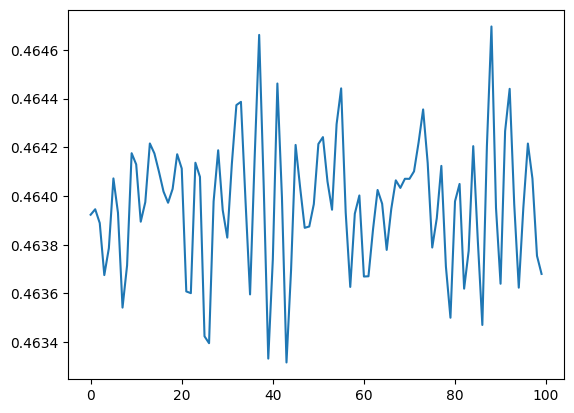

In [116]:
# Generate random index
ims = IMS_X_0[:, 0, :]
cwru = CWRU_X_all[:, 0, :]
y_cwru = CWRU_y_all[:]

y_ims = IMS_y_0[:]
#y_ims[y_ims == 2] = 1
#y_ims[y_ims != 2] = 0
#model.fit(ims, y_ims.reshape(-1))
#model.score(cwru, y_cwru.reshape(-1))

#plt.boxplot(ims[(y_ims == 0).reshape(-1), :].mean(axis=1))
#plt.boxplot(ims[(y_ims == 1).reshape(-1), :].mean(axis=1))
#plt.boxplot(ims[(y_ims == 2).reshape(-1), :].mean(axis=1))
#plt.boxplot(ims[(y_ims == 3).reshape(-1), :].mean(axis=1)
cs = CubicSpline(np.arange(0, 2048), ims.mean(axis=0).reshape(-1))
xs = np.arange(0, 2048, 1)
cs_xs = cs(xs)
#plt.plot(cs_xs[:100])
plt.plot(cwru.mean(axis=0)[:100])


#y_cwru[y_cwru == 2] = 1
#y_cwru[y_cwru != 2] = 0



In [32]:
cs = CubicSpline(np.arange(0, 2048), ims)
xs = np.arange(0, 2048, 0.1)
cs_xs = cs(xs)

NameError: name 'xs' is not defined

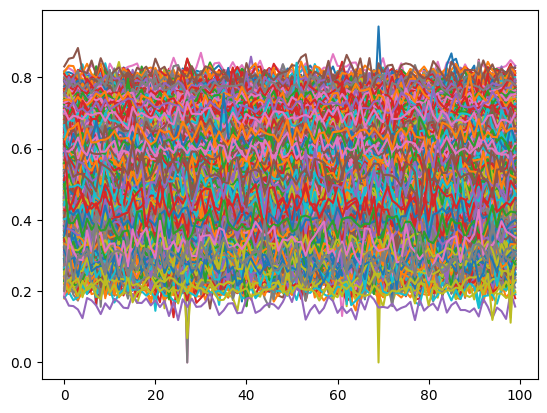

In [64]:

plt.plot(ims[:100], label="cubic spline")
plt.plot(xs[:1000], cs_xs[:1000], label="cubic spline")